# Establish a baseline Poisson Regression Model
- Use the International soccer database (ISDB) to predict the goals scored by each team.
- Database Description:
    - ISDBv2: 218,916 entries. 52 leagues, from 2000/01 to 2016/17 seasons
              completed leagues only.
    - ISDBv1: 216,743 entries. 52 leagues, from 2000/01 to 2017/18 seasons.
              Some leagues incomplete and some cover only subset of seasons.
- Metadata:
    - `'Date'`: Date on which the match took place.
    - `'Sea'` : Describes the yearly season in which the match happened.
    - `'Lea'` : League of in which the match is part of.
    - `'HT'`  : Home Team.
    - `'AT'`  : Away Team.
    - `'HS'`  : Goals scored by Home Team.
    - `'AS'`  : Goals scored by Away Team.
    - `'GD'`  : Goal difference (`HS - AS`)
    - `'WDL'` : Match outcome w/r to Home team (home win, home loss, draw)
- Use the poisson regressor of the GLM model in stats models
- Evaluate the model performance

In [1]:
import logging
import warnings

import numpy as np
import pandas as pd

import helpers.hdbg as hdbg
import research_amp.soccer_prediction.models as rasoprmo
import research_amp.soccer_prediction.preprocessing as rasoprpr
import research_amp.soccer_prediction.utils as rasoprut

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

/app/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [2]:
_LOG = logging.getLogger(__name__)

In [3]:
def calculate_match_outcome_and_probabilities(
    df: pd.DataFrame,
    *,
    max_goals: int = 10,
    apply_dixon_coles: bool = False,
    rho: float = -0.2,
) -> pd.DataFrame:
    """
    Calculate match outcome probabilities for the entire DataFrame.

    :param df: Input DataFrame with predicted goals.
    :param max_goals: Maximum goals to consider for calculating the
        probabilities.
    :param apply_dixon_coles: Flag to apply Dixon-Coles adjustment.
    :param rho: Dixon-Coles adjustment parameter.
    :return: DataFrame with added probabilities for home win, away win,
        and draw.
    """
    hdbg.dassert_isinstance(df, pd.DataFrame)
    # Calculate Poisson probabilities for Home team goals.
    home_goals_probs = np.array(
        [
            np.exp(-df["Lambda_HS"]) * df["Lambda_HS"] ** i / np.math.factorial(i)
            for i in range(max_goals)
        ]
    )
    # Calculate Poisson probabilities for Away team goals.
    away_goals_probs = np.array(
        [
            np.exp(-df["Lambda_AS"]) * df["Lambda_AS"] ** i / np.math.factorial(i)
            for i in range(max_goals)
        ]
    )
    # Initialize probabilities.
    prob_home_win = np.zeros(len(df))
    prob_away_win = np.zeros(len(df))
    prob_draw = np.zeros(len(df))
    # Calculate the probabilities of home win, away win, and draw.
    for i in range(max_goals):
        for j in range(max_goals):
            prob = home_goals_probs[i] * away_goals_probs[j]
            if apply_dixon_coles:
                prob *= dixon_coles_adjustment(
                    i, j, df["Lambda_HS"], df["Lambda_AS"], rho
                )
            prob_home_win += np.where(i > j, prob, 0)
            prob_away_win += np.where(i < j, prob, 0)
            prob_draw += np.where(i == j, prob, 0)
    # Add probabilities to the DataFrame.
    df["prob_home_win"] = prob_home_win
    df["prob_away_win"] = prob_away_win
    df["prob_draw"] = prob_draw
    # Predict the outcomes based on probabilities.
    df["predicted_outcome"] = np.where(
        df["prob_home_win"] > df["prob_away_win"],
        "home_win",
        np.where(df["prob_away_win"] > df["prob_home_win"], "away_win", "draw"),
    )
    # Calculate actual outcomes for comparison.
    df["actual_outcome"] = np.where(
        df["HS"] > df["AS"],
        "home_win",
        np.where(df["HS"] < df["AS"], "away_win", "draw"),
    )
    # Round off the predicted goals to integers.
    df["Lambda_HS"] = df["Lambda_HS"].round().astype(int)
    df["Lambda_AS"] = df["Lambda_AS"].round().astype(int)
    print(df.head())
    return df


def poisson_model(label_encode: bool = False):
    # Define the S3 Buckets, dataset path and local directory for download.
    bucket = "cryptokaizen-data-test"
    dataset_path = "kaizen_ai/soccer_prediction/datasets/OSF_football/"
    local_dir = "datasets/OSF_football"
    # Download data from S3.
    rasoprut.download_data_from_s3(
        bucket_name=bucket, dataset_path=dataset_path, local_path=local_dir
    )
    # Load the data from S3 into pandas dataframe objects.
    dataframes = rasoprut.load_data_to_dataframe(local_path=local_dir)
    # Access the dataframes directly from the dictionary.
    dataframes.get("ISDBv1_df")
    ISDBv2_df = dataframes.get("ISDBv2_df")
    rasoprut.compute_stats(ISDBv2_df)
    # Preprocess and unravel data.
    preprocessed_df, pipeline = rasoprpr.preprocess_and_unravel_data(
        ISDBv2_df, add_epsilon_flag=True
    )
    train_df = preprocessed_df.get("train_df")
    test_df = preprocessed_df.get("test_df")
    # Train model
    hyperparameters = {
        "formula": "goals~ team - opponent + is_home",
        "maxiter": 10,
    }
    sample_sizes = [20000, 30000, 40000, 50000, 60000]
    columns = ["team", "opponent", "goals", "is_home"]
    poisson_model = rasoprmo.PoissonModel()
    trained_model = rasoprmo.train_model(
        train_df[columns],
        poisson_model,
        hyperparameters,
        sample_sizes=sample_sizes,
    )
    # Generate predictions.
    test_df["predicted_goals"] = trained_model.predict(
        test_df[["team", "opponent", "is_home"]]
    )
    # Recombine predictions.
    final_df = rasoprut.recombine_predictions(test_df)
    # Calculate match outcome probabilities.
    final_df = calculate_match_outcome_and_probabilities(final_df)
    # Evaluate model.
    rasoprut.evaluate_model_predictions(
        final_df["actual_outcome"], final_df["predicted_outcome"]
    )
    # Inverse transform.
    if label_encode:
        pipeline.named_steps["label_encoding"].inverse_transform(final_df)
    # Save data to S3.
    s3_path_predictions = "kaizen_ai/soccer_prediction/model_output/glm_poisson"
    rasoprut.save_data_to_s3(
        df=final_df,
        bucket_name=bucket,
        s3_path=s3_path_predictions,
        file_name="glm_poisson_predictions",
    )

INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv1.txt to datasets/OSF_football/ISDBv1.txt
INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt to datasets/OSF_football/ISDBv2.txt
INFO:research_amp.soccer_prediction.utils:Data Downloaded.
INFO:research_amp.soccer_prediction.utils:Loading datasets/OSF_football/ISDBv1.txt
INFO:research_amp.soccer_prediction.utils: ISDBv1_df,  (216743, 9)
INFO:research_amp.soccer_prediction.utils:Loading datasets/OSF_football/ISDBv2.txt
INFO:research_amp.soccer_prediction.utils: ISDBv2_df,  (218916, 9)
INFO:research_amp.soccer_prediction.utils:Data loaded into dataframes.
INFO:research_amp.soccer_prediction.utils:Value Counts:
WDL
W    99459
L    60188
D    59269
INFO:research_amp.soccer_prediction.utils:
Prior Probabilities:
WDL
W    0.454325
L    0.274937
D    0.270739
INFO:research_amp.soccer_prediction.preproccesing:Rows removed af

INFO:research_amp.soccer_prediction.models:Sample Size: 20000.000000, Train MAE: 0.885605, Validation MAE: 0.956635
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                24000
Model:                            GLM   Df Residuals:                    22745
Model Family:                 Poisson   Df Model:                         1254
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32567.
Date:                Mon, 17 Jun 2024   Deviance:                       13718.
Time:                        21:10:44   Pearson chi2:                 1.53e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.07807
Covariance Type:            nonrobust               

INFO:research_amp.soccer_prediction.models:Sample Size: 30000.000000, Train MAE: 0.905732, Validation MAE: 0.942181
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                32000
Model:                            GLM   Df Residuals:                    30740
Model Family:                 Poisson   Df Model:                         1259
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43505.
Date:                Mon, 17 Jun 2024   Deviance:                       18549.
Time:                        21:11:56   Pearson chi2:                 2.08e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06870
Covariance Type:            nonrobust               

INFO:research_amp.soccer_prediction.models:Sample Size: 40000.000000, Train MAE: 0.912811, Validation MAE: 0.946903
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                40000
Model:                            GLM   Df Residuals:                    38740
Model Family:                 Poisson   Df Model:                         1259
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54517.
Date:                Mon, 17 Jun 2024   Deviance:                       23451.
Time:                        21:14:02   Pearson chi2:                 2.64e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            0.06314
Covariance Type:            nonrobust               

INFO:research_amp.soccer_prediction.models:Sample Size: 50000.000000, Train MAE: 0.917394, Validation MAE: 0.941100
INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                48000
Model:                            GLM   Df Residuals:                    46738
Model Family:                 Poisson   Df Model:                         1261
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65401.
Date:                Mon, 17 Jun 2024   Deviance:                       28188.
Time:                        21:15:22   Pearson chi2:                 3.18e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06152
Covariance Type:            nonrobust               

INFO:research_amp.soccer_prediction.models:Sample Size: 60000.000000, Train MAE: 0.917014, Validation MAE: 0.941408


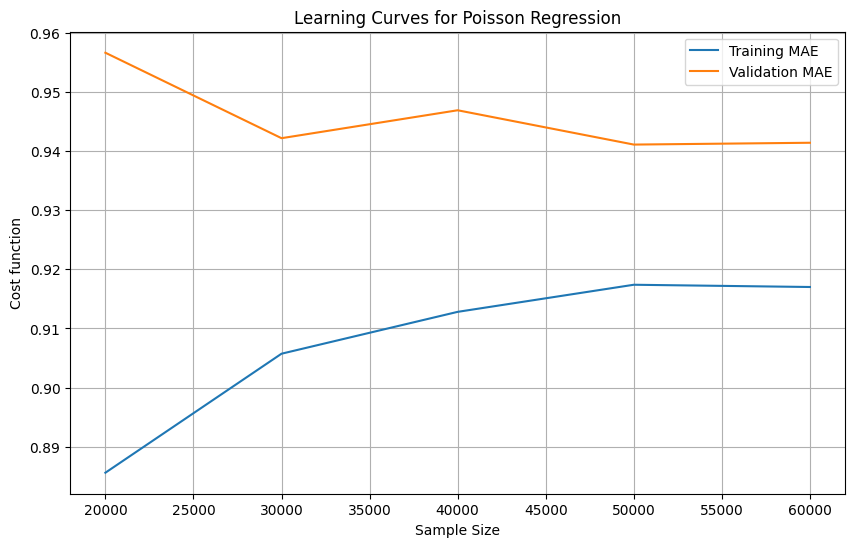

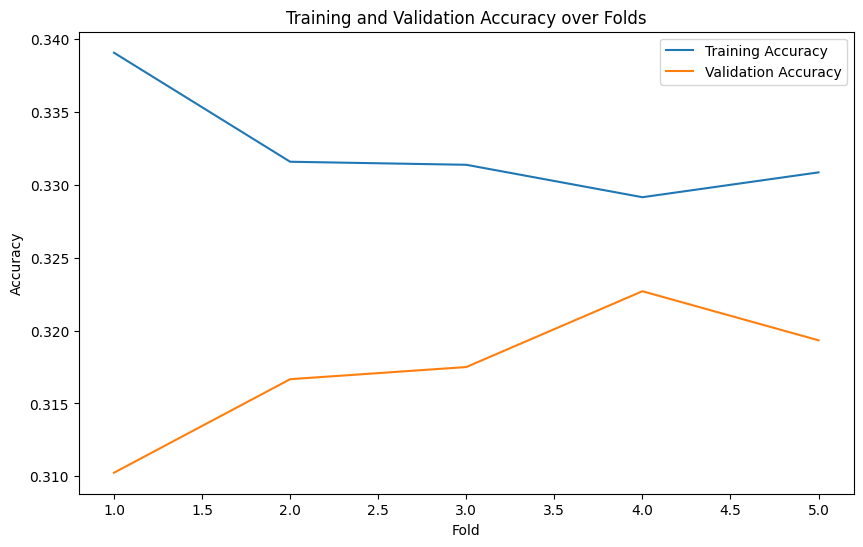

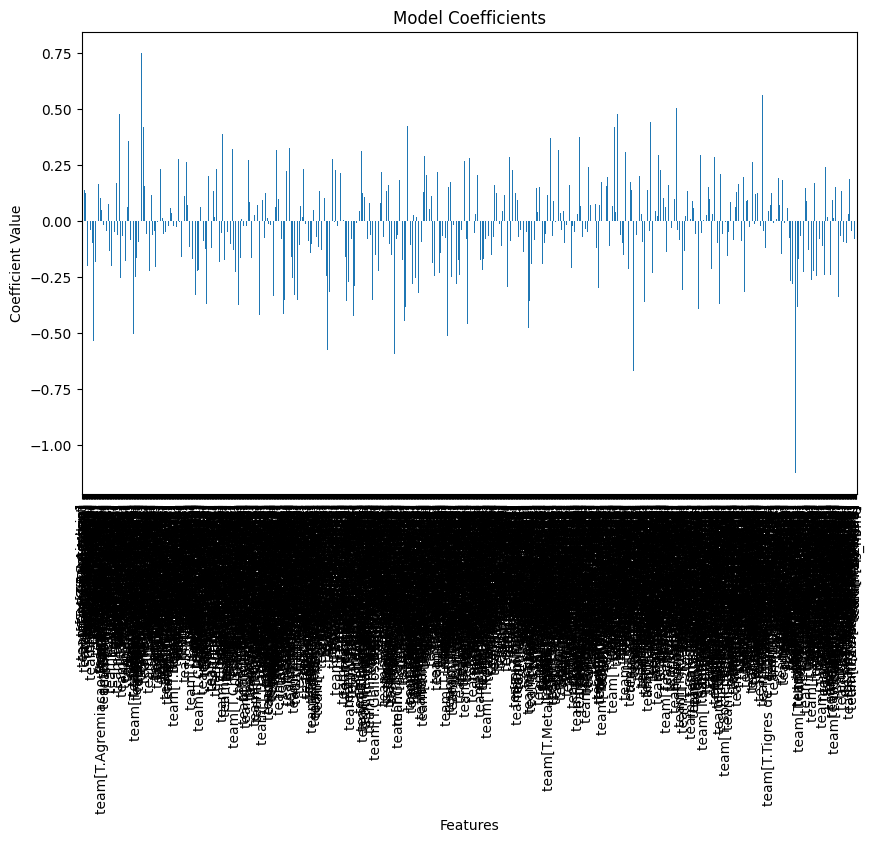

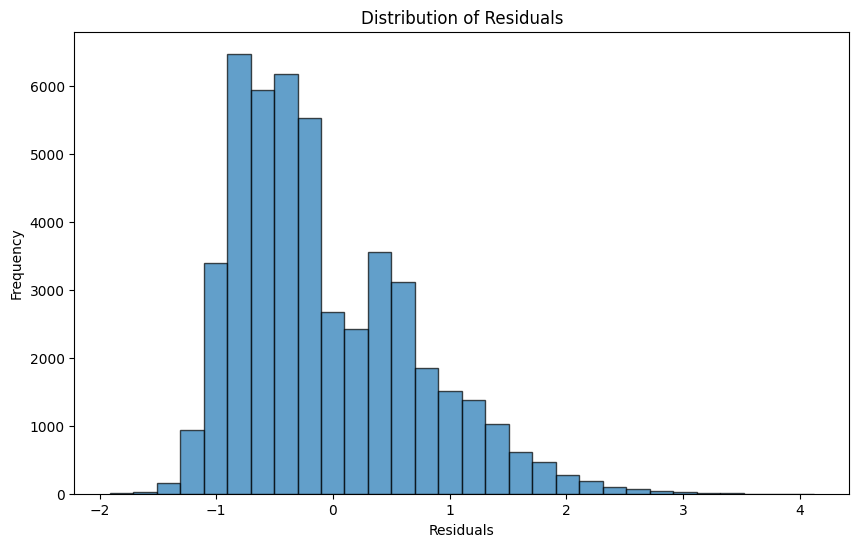

INFO:research_amp.soccer_prediction.models:Poisson model fitted successfully.
INFO:research_amp.soccer_prediction.models:                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                60000
Model:                            GLM   Df Residuals:                    58738
Model Family:                 Poisson   Df Model:                         1261
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81917.
Date:                Mon, 17 Jun 2024   Deviance:                       35502.
Time:                        21:17:04   Pearson chi2:                 4.01e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.05778
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|    

INFO:research_amp.soccer_prediction.utils:Counts of each type of class prediction: 
predicted_outcome
home_win    20563
away_win     3728
Name: count, dtype: int64
INFO:research_amp.soccer_prediction.utils:Counts of each type of actual outcomes: 
actual_outcome
home_win    10919
away_win     6760
draw         6612
Name: count, dtype: int64


        Date    Sea   Lge                       HT                 AT   HS  \
0 2014-12-20  14-15  ENG5                   Woking          Southport  1.0   
1 2014-02-08  13-14  GER3               Heidenheim       Darmstadt 98  1.0   
2 2015-03-21  14-15  AUS1          Adelaide United  Melbourne Victory  2.0   
3 2012-11-10  12-13  BRA1  Botafogo Rio de Janeiro         Portuguesa  3.0   
4 2010-10-01  10-11  FRA2                    Sedan             Istres  5.0   

    AS  Lambda_HS  Lambda_AS  prob_home_win  prob_away_win  prob_draw  \
0  2.0          2          1       0.536372       0.245469   0.218117   
1  1.0          2          1       0.506173       0.251667   0.242148   
2  2.0          2          1       0.420546       0.340777   0.238666   
3  0.5          2          1       0.415059       0.348859   0.236069   
4  1.0          2          1       0.470332       0.300944   0.228701   

  predicted_outcome actual_outcome  
0          home_win       away_win  
1          home_wi

In [9]:
poisson_model()

In [27]:
# Load predictions dataset.
bucket = "cryptokaizen-data-test"
dataset_path = "kaizen_ai/soccer_prediction/model_output/glm_poisson/"
local_dir = "model_output/glm_poisson"
# Download data from S3.
rasoprut.download_data_from_s3(
    bucket_name=bucket, dataset_path=dataset_path, local_path=local_dir, file_format = ".csv"
)
# Load the data from S3 into pandas dataframe objects.
dataframes = rasoprut.load_data_to_dataframe(local_path=local_dir, file_format = ".csv", sep = ",")
glm_poisson_prediction_df = dataframes["glm_poisson_predictions_df"]


# Dixon-Coles predictions.
def dixon_coles_adjustment(home_goals, away_goals, mu_home, mu_away, rho):
    """
    Apply Dixon-Coles adjustment for low-scoring outcomes.
    
    :param home_goals: Number of goals scored by home team.
    :param away_goals: Number of goals scored by away team.
    :param mu_home: Expected goals for home team.
    :param mu_away: Expected goals for away team.
    :param rho: Dixon-Coles adjustment parameter.
    :return: Adjustment factor.
    """
    # Implement Dixon-Coles adjustment.
    if home_goals <1 and away_goals <1:
        if home_goals == away_goals:
            adjustment = 1 + rho
        elif home_goals != away_goals:
            adjustment = 1 - rho
    else:
        adjustment = 1
    return adjustment


final_df_with_dixon = calculate_match_outcome_and_probabilities(glm_poisson_prediction_df, max_goals=10, apply_dixon_coles=True, rho=0.13)
# Evaluate model.
rasoprut.evaluate_model_predictions(
        final_df_with_dixon["actual_outcome"], final_df_with_dixon["predicted_outcome"]
    )


def calculate_rps(df: pd.DataFrame) -> float:
    """
    Calculate the Rank Probability Score (RPS) for three-way outcome predictions in a DataFrame.

    :param df: DataFrame containing the columns:
                       'prob_home_win', 'prob_draw', 'prob_away_win',
                       'actual_outcome'.
    :return: The Rank Probability Score (RPS) for the entire model.
    """
    # Initialize RPS sum.
    rps_sum = 0
    M = len(df)
    # Iterate over each row in the DataFrame.
    for index, row in df.iterrows():
        # Extract predicted probabilities
        probs = np.array([row['prob_home_win'], row['prob_draw']])
        # Calculate cumulative predicted probabilities.
        cum_probs = probs.cumsum()
        # Determine actual outcomes.
        if row['actual_outcome'] == 'home_win':
            actuals = np.array([1, 0])
        elif row['actual_outcome'] == 'draw':
            actuals = np.array([0, 1])
        else:
            actuals = np.array([0, 0])
        # Calculate cumulative actual outcomes.
        cum_actuals = actuals.cumsum()
        # Calculate RPS for the current match.
        rps = (np.sum((cum_probs - cum_actuals) ** 2)) / 2
        # Add the RPS of the current match to the total RPS sum.
        rps_sum += rps
    # Average RPS over all matches.
    rps_avg = rps_sum / M
    _LOG.info("RPS value for the model: %.4f", rps_avg)
    return rps_avg


def calculate_rps_modified(df: pd.DataFrame) -> float:
    """
    Calculate the Rank Probability Score (RPS) for three-way outcome predictions in a DataFrame.

    :param df: DataFrame containing the columns:
                       'prob_home_win', 'prob_draw', 'prob_away_win',
                       'actual_outcome'.
    :return: The Rank Probability Score (RPS) for the entire model.
    """
    # Initialize RPS sum.
    rps_sum = 0
    M = len(df)
    # Iterate over each row in the DataFrame.
    for index, row in df.iterrows():
        # Extract predicted probabilities
        probs = np.array([row['prob_home_win'], row['prob_draw']])
        # Determine actual outcomes.
        if row['actual_outcome'] == 'home_win':
            actuals = np.array([1, 0])
        elif row['actual_outcome'] == 'draw':
            actuals = np.array([0, 1])
        else:
            actuals = np.array([0, 0])
        # Calculate RPS for the current match.
        rps = (np.sum((probs - actuals) ** 2)) / 2
        # Add the RPS of the current match to the total RPS sum.
        rps_sum += rps
    # Average RPS over all matches.
    rps_avg = rps_sum / M
    _LOG.info("RPS value for the model: %.4f", rps_avg)
    return rps_avg


rps_avg = calculate_rps(glm_poisson_prediction_df)
rps_avg_new = calculate_rps_modified(glm_poisson_prediction_df)

INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/model_output/glm_poisson/glm_poisson_predictions.csv to model_output/glm_poisson/glm_poisson_predictions.csv
INFO:research_amp.soccer_prediction.utils:Downloading kaizen_ai/soccer_prediction/model_output/glm_poisson/glm_poisson_predictions_new.csv to model_output/glm_poisson/glm_poisson_predictions_new.csv
INFO:research_amp.soccer_prediction.utils:Data Downloaded.
INFO:research_amp.soccer_prediction.utils:Loading model_output/glm_poisson/glm_poisson_predictions.csv
INFO:research_amp.soccer_prediction.utils: glm_poisson_predictions_df,  (24291, 14)
INFO:research_amp.soccer_prediction.utils:Loading model_output/glm_poisson/glm_poisson_predictions_new.csv
INFO:research_amp.soccer_prediction.utils: glm_poisson_predictions_new_df,  (24291, 14)
INFO:research_amp.soccer_prediction.utils:Data loaded into dataframes.
INFO:research_amp.soccer_prediction.utils:Counts of each type of class prediction: 
predicted_outc

         Date    Sea   Lge                       HT                 AT   HS  \
0  2014-12-20  14-15  ENG5                   Woking          Southport  1.0   
1  2014-02-08  13-14  GER3               Heidenheim       Darmstadt 98  1.0   
2  2015-03-21  14-15  AUS1          Adelaide United  Melbourne Victory  2.0   
3  2012-11-10  12-13  BRA1  Botafogo Rio de Janeiro         Portuguesa  3.0   
4  2010-10-01  10-11  FRA2                    Sedan             Istres  5.0   

    AS  Lambda_HS  Lambda_AS  prob_home_win  prob_away_win  prob_draw  \
0  2.0          2          1       0.605657       0.182585   0.218184   
1  1.0          2          1       0.605657       0.182585   0.218184   
2  2.0          2          1       0.605657       0.182585   0.218184   
3  0.5          2          1       0.605657       0.182585   0.218184   
4  1.0          2          1       0.605657       0.182585   0.218184   

  predicted_outcome actual_outcome  
0          home_win       away_win  
1          h

INFO:__main__:RPS value for the model: 0.2283
INFO:__main__:RPS value for the model: 0.2264
